In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf

# Function to load all frames from a video directory and associate labels
def load_frames_with_labels(video_dir, label, num_classes=2):
    frames = []
    for frame_file in sorted(os.listdir(video_dir)):
        frame_path = os.path.join(video_dir, frame_file)
        if frame_file.endswith('.jpg') or frame_file.endswith('.png'):  # Adjust as per your frame format
            image = tf.io.read_file(frame_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [128, 128])  # Resize to desired dimensions
            #image = image / 255.
            
            label_one_hot = tf.one_hot(label, num_classes)  # One-hot encode the label
            frames.append((image, label_one_hot))  # Append frame with its one-hot encoded label
    return frames

# Function to create dataset with labels for each frame
def create_dataset_with_labels(fake_dir, real_dir, max_videos=200, split_ratio=0.8):
    labeled_frames = []
    train_frames = []
    test_frames = []

    # Load fake videos
    fake_count = 0
    for video_name in os.listdir(fake_dir):
        if fake_count >= max_videos:
            break  # Stop if we have enough fake videos
        video_path = os.path.join(fake_dir, video_name)
        if os.path.isdir(video_path):
            # Load frames and associate label 1 for fake
            frames_with_labels = load_frames_with_labels(video_path, 1)
            split_index = int(len(frames_with_labels) * split_ratio)
            train_frames.extend(frames_with_labels[:split_index])
            test_frames.extend(frames_with_labels[split_index:])
            labeled_frames.extend(frames_with_labels)  # Add to the dataset
            fake_count += 1  # Increment the count of fake videos
            print(f'Loaded fake video {fake_count}')

    # Load real videos
    real_count = 0
    for video_name in os.listdir(real_dir):
        if real_count >= max_videos:
            break  # Stop if we have enough real videos
        video_path = os.path.join(real_dir, video_name)
        if os.path.isdir(video_path):
            # Load frames and associate label 0 for real
            frames_with_labels = load_frames_with_labels(video_path, 0)
            split_index = int(len(frames_with_labels) * split_ratio)
            train_frames.extend(frames_with_labels[:split_index])
            test_frames.extend(frames_with_labels[split_index:])
            labeled_frames.extend(frames_with_labels)  # Add to the dataset
            real_count += 1  # Increment the count of real videos
            print(f'Loaded real video {real_count}')

    return labeled_frames, train_frames, test_frames

# Define paths
BASE_DIR = '/kaggle/input/dfdc-facial-cropped-videos-dataset-jpg-frames/DFDC'
FAKE_DIR = os.path.join(BASE_DIR, 'FAKE', 'TRAIN')
REAL_DIR = os.path.join(BASE_DIR, 'REAL', 'TRAIN')

# Create dataset with labels for each frame, loading up to 200 video folders from both categories
labeled_dataset, train_dataset, test_dataset = create_dataset_with_labels(FAKE_DIR, REAL_DIR, max_videos=200, split_ratio=0.8)

Loaded fake video 1
Loaded fake video 2
Loaded fake video 3
Loaded fake video 4
Loaded fake video 5
Loaded fake video 6
Loaded fake video 7
Loaded fake video 8
Loaded fake video 9
Loaded fake video 10
Loaded fake video 11
Loaded fake video 12
Loaded fake video 13
Loaded fake video 14
Loaded fake video 15
Loaded fake video 16
Loaded fake video 17
Loaded fake video 18
Loaded fake video 19
Loaded fake video 20
Loaded fake video 21
Loaded fake video 22
Loaded fake video 23
Loaded fake video 24
Loaded fake video 25
Loaded fake video 26
Loaded fake video 27
Loaded fake video 28
Loaded fake video 29
Loaded fake video 30
Loaded fake video 31
Loaded fake video 32
Loaded fake video 33
Loaded fake video 34
Loaded fake video 35
Loaded fake video 36
Loaded fake video 37
Loaded fake video 38
Loaded fake video 39
Loaded fake video 40
Loaded fake video 41
Loaded fake video 42
Loaded fake video 43
Loaded fake video 44
Loaded fake video 45
Loaded fake video 46
Loaded fake video 47
Loaded fake video 48
L

In [2]:
#Convert to TensorFlow Dataset format
def create_tf_dataset(labeled_data):
    # Unzip the labeled_data into frames and labels
    frames, labels = zip(*labeled_data)
    
    # Create a TensorFlow Dataset from the frames and labels
    tf_dataset = tf.data.Dataset.from_tensor_slices((tf.stack(frames), tf.convert_to_tensor(labels)))
    
    return tf_dataset

# Create TensorFlow datasets
tf_dataset = create_tf_dataset(labeled_dataset)
train_tf_dataset = create_tf_dataset(train_dataset)
test_tf_dataset = create_tf_dataset(test_dataset)

# Shuffle the datasets
tf_dataset = tf_dataset.shuffle(buffer_size=len(labeled_dataset), reshuffle_each_iteration=True)
train_tf_dataset = train_tf_dataset.shuffle(buffer_size=len(train_dataset), reshuffle_each_iteration=True)
test_tf_dataset = test_tf_dataset.shuffle(buffer_size=len(test_dataset), reshuffle_each_iteration=True)

# Batch the datasets
tf_dataset = tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_tf_dataset = train_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Example of checking the shape of the loaded frames and their labels
print("Full dataset:")
for frame, label in tf_dataset.take(5):  # Display the first 5 frames and their labels
    print(f'Frame shape: {frame.shape}, Label: {label.numpy()}')

print("\nTraining dataset:")
for frame, label in train_tf_dataset.take(5):  # Display the first 5 frames and their labels
    print(f'Frame shape: {frame.shape}, Label: {label.numpy()}')

print("\nTesting dataset:")
for frame, label in test_tf_dataset.take(5):  # Display the first 5 frames and their labels
    print(f'Frame shape: {frame.shape}, Label: {label.numpy()}')

Full dataset:
Frame shape: (32, 128, 128, 3), Label: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Frame shape: (32, 128, 128, 3), Label: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Frame shape: (32, 128, 128, 3), Label: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Fr

Frames shape: (32, 128, 128, 3)
Labels: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


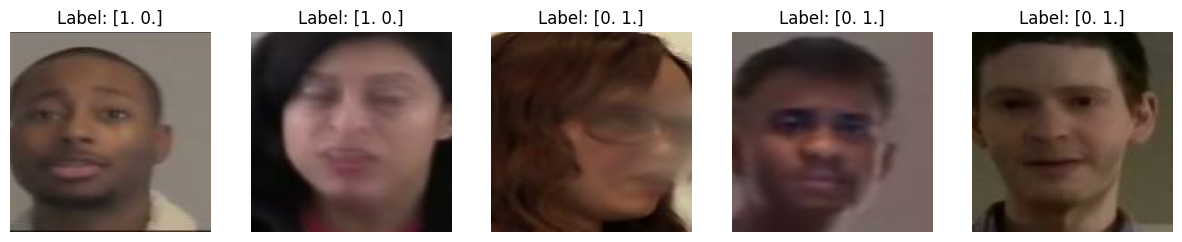

In [3]:
import matplotlib.pyplot as plt

# Function to plot frames
def plot_frames(frames, labels):
    num_frames = 5  # Number of frames in the batch
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    
    for i in range(num_frames):
        axes[i].imshow(frames[i].numpy().astype("uint8"))  # Convert tensor to numpy array for plotting
        axes[i].axis('off')  # Hide axes
        axes[i].set_title(f'Label: {labels[i].numpy()}')  # Set title with label

    plt.show()

# Example of iterating through the dataset to plot frames
for frames, labels in tf_dataset.take(1):  # Take one batch from the dataset
    print("Frames shape:", frames.shape)  # Should be (batch_size, 128, 128, 3)
    print("Labels:", labels.numpy())
    
    # Plot the frames
    plot_frames(frames, labels)

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4,EfficientNetB7,EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomZoom, RandomBrightness, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_base_learner(model_cls, input_shape=(128, 128, 3), num_classes=2):
    # Create the base model
        
    base_model = model_cls(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze all layers except the new ones
    
    base_model.trainable = True
    
    for layer in base_model.layers[:-10]:
        
        layer.trainable = False
    
    # Define the data augmentation layers
    data_aug = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomFlip('vertical'),
        RandomZoom(0.1),
        RandomRotation(0.1),
        RandomBrightness(0.1),
        RandomContrast(0.1)
    ], name="data_aug")
    
   
    
    # Apply data augmentation to the input
    inputs = Input(shape=input_shape)
    x = data_aug(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    
        
    return model

# Initialize the base learners
base_learners = [
    create_base_learner(EfficientNetB0),
    create_base_learner(EfficientNetB3),
    create_base_learner(EfficientNetB4),
    create_base_learner(EfficientNetB7)
]

# Compile each model with appropriate loss and optimizer
for model in base_learners:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','auc','recall'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [5]:
# Fit each model
tf.keras.backend.clear_session()

for i, model in enumerate(base_learners):
    print(f"Training model {i + 1}/{len(base_learners)}: {model.name}")
    history = model.fit(
        train_tf_dataset,    # Your training dataset
        validation_data=test_tf_dataset,  # Your validation dataset
        epochs=20,           # Number of epochs
        batch_size=32,       # Batch size (optional, if using dataset)
        verbose=1            # Verbosity mode
    )
    print(f"Finished training model {i + 1}/{len(base_learners)}: {model.name}")


Training model 1/4: functional_2
Epoch 1/20


2024-09-03 14:04:01.297785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


638/638 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - accuracy: 0.7455 - auc: 0.8200 - loss: 0.5258 - precision: 0.7455 - recall: 0.7455 - val_accuracy: 0.8417 - val_auc: 0.9252 - val_loss: 0.3539 - val_precision: 0.8417 - val_recall: 0.8417
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8503 - auc: 0.9323 - loss: 0.3306 - precision: 0.8503 - recall: 0.8503 - val_accuracy: 0.8617 - val_auc: 0.9376 - val_loss: 0.3253 - val_precision: 0.8617 - val_recall: 0.8617
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8766 - auc: 0.9516 - loss: 0.2807 - precision: 0.8766 - recall: 0.8766 - val_accuracy: 0.8804 - val_auc: 0.9509 - val_loss: 0.2958 - val_precision: 0.8804 - val_recall: 0.8804
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8956 - auc: 0.9643 - loss: 0.2413 - precision: 0.8956 - recall: 0.8956 - val_accuracy: 0.8921 - val_auc: 0.9598 - val_loss: 0.2615 - val_precision: 0.8921 - val_recall: 0.8921
Epoch 5/20
638/638 ━━━━━━━━━━━━━━━━

2024-09-03 14:11:16.069803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


638/638 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.6924 - auc: 0.7593 - loss: 0.5935 - precision: 0.6924 - recall: 0.6924 - val_accuracy: 0.7973 - val_auc: 0.8790 - val_loss: 0.4388 - val_precision: 0.7973 - val_recall: 0.7973
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8031 - auc: 0.8878 - loss: 0.4197 - precision: 0.8031 - recall: 0.8031 - val_accuracy: 0.8187 - val_auc: 0.9051 - val_loss: 0.3961 - val_precision: 0.8187 - val_recall: 0.8187
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8296 - auc: 0.9127 - loss: 0.3737 - precision: 0.8296 - recall: 0.8296 - val_accuracy: 0.8212 - val_auc: 0.9035 - val_loss: 0.4153 - val_precision: 0.8212 - val_recall: 0.8212
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8471 - auc: 0.9294 - loss: 0.3370 - precision: 0.8471 - recall: 0.8471 - val_accuracy: 0.8635 - val_auc: 0.9323 - val_loss: 0.3451 - val_precision: 0.8635 - val_recall: 0.8635
Epoch 5/20
638/638 ━━━━━━━━━━━━━━━━

2024-09-03 14:22:19.467224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_8_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


638/638 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.6894 - auc: 0.7561 - loss: 0.5939 - precision: 0.6894 - recall: 0.6894 - val_accuracy: 0.7815 - val_auc: 0.8709 - val_loss: 0.4501 - val_precision: 0.7815 - val_recall: 0.7815
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7754 - auc: 0.8655 - loss: 0.4544 - precision: 0.7754 - recall: 0.7754 - val_accuracy: 0.8273 - val_auc: 0.9052 - val_loss: 0.3949 - val_precision: 0.8273 - val_recall: 0.8273
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8133 - auc: 0.8987 - loss: 0.4013 - precision: 0.8133 - recall: 0.8133 - val_accuracy: 0.7954 - val_auc: 0.8878 - val_loss: 0.4430 - val_precision: 0.7954 - val_recall: 0.7954
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8355 - auc: 0.9182 - loss: 0.3623 - precision: 0.8355 - recall: 0.8355 - val_accuracy: 0.8198 - val_auc: 0.9111 - val_loss: 0.3884 - val_precision: 0.8198 - val_recall: 0.8198
Epoch 5/20
638/638 ━━━━━━━━━━━━━━━━

2024-09-03 14:37:13.255912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_11_1/efficientnetb7_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


638/638 ━━━━━━━━━━━━━━━━━━━━ 134s 151ms/step - accuracy: 0.6807 - auc: 0.7435 - loss: 0.6093 - precision: 0.6807 - recall: 0.6807 - val_accuracy: 0.7898 - val_auc: 0.8772 - val_loss: 0.4407 - val_precision: 0.7898 - val_recall: 0.7898
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.7922 - auc: 0.8743 - loss: 0.4433 - precision: 0.7922 - recall: 0.7922 - val_accuracy: 0.8288 - val_auc: 0.9099 - val_loss: 0.3827 - val_precision: 0.8288 - val_recall: 0.8288
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.8333 - auc: 0.9134 - loss: 0.3720 - precision: 0.8333 - recall: 0.8333 - val_accuracy: 0.8448 - val_auc: 0.9239 - val_loss: 0.3519 - val_precision: 0.8448 - val_recall: 0.8448
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.8458 - auc: 0.9271 - loss: 0.3428 - precision: 0.8458 - recall: 0.8458 - val_accuracy: 0.8702 - val_auc: 0.9412 - val_loss: 0.3097 - val_precision: 0.8702 - val_recall: 0.8702
Epoch 5/20
638/638 ━━━━━━━━━━━

In [9]:
# Optionally, you can save each model's weights after training

for i, model in enumerate(base_learners):
    model.save_weights(f'/kaggle/working/efficientnet_model_{i + 1}_weights.weights.h5')

In [10]:
# Define paths
BASE_DIR = '/kaggle/input/dfdc-facial-cropped-videos-dataset-jpg-frames/DFDC'
FAKE_DIR = os.path.join(BASE_DIR, 'FAKE', 'TEST')
REAL_DIR = os.path.join(BASE_DIR, 'REAL', 'TEST')

# Create dataset with labels for each frame, loading up to 200 video folders from both categories
labeled_dataset_2, train_dataset_2, test_dataset_2 = create_dataset_with_labels(FAKE_DIR, REAL_DIR, max_videos=200, split_ratio=0.8)

Loaded fake video 1
Loaded fake video 2
Loaded fake video 3
Loaded fake video 4
Loaded fake video 5
Loaded fake video 6
Loaded fake video 7
Loaded fake video 8
Loaded fake video 9
Loaded fake video 10
Loaded fake video 11
Loaded fake video 12
Loaded fake video 13
Loaded fake video 14
Loaded fake video 15
Loaded fake video 16
Loaded fake video 17
Loaded fake video 18
Loaded fake video 19
Loaded fake video 20
Loaded fake video 21
Loaded fake video 22
Loaded fake video 23
Loaded fake video 24
Loaded fake video 25
Loaded fake video 26
Loaded fake video 27
Loaded fake video 28
Loaded fake video 29
Loaded fake video 30
Loaded fake video 31
Loaded fake video 32
Loaded fake video 33
Loaded fake video 34
Loaded fake video 35
Loaded fake video 36
Loaded fake video 37
Loaded fake video 38
Loaded fake video 39
Loaded fake video 40
Loaded fake video 41
Loaded fake video 42
Loaded fake video 43
Loaded fake video 44
Loaded fake video 45
Loaded fake video 46
Loaded fake video 47
Loaded fake video 48


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Squeeze: Dst tensor is not initialized. [Op:Squeeze] name: 